# 循环神经网络的简洁实现
:label:`sec_rnn-concise`

虽然 :numref:`sec_rnn_scratch` 对了解循环神经网络的实现方式具有指导意义，但并不方便。本节将展示如何使用深度学习框架的高级API提供的函数更有效地实现相同的语言模型。我们仍然从读取时光机器数据集开始。


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**定义模型**]

高级API提供了循环神经网络的实现。我们构造了一个具有256个隐藏单元的单隐藏层的循环神经网络层 `rnn_layer`。事实上，我们还没有讨论多层的意义——这将在 :numref:`sec_deep_rnn`中介绍。现在，仅需要将多层理解为一层循环神经网络的输出被用作下一层循环神经网络的输入就足够了。


In [2]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

我们(**使用张量来初始化隐藏状态**)，它的形状是（隐藏层数，批量大小，隐藏单元数）。


In [3]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

[**通过一个隐藏状态和一个输入，我们就可以用更新后的隐藏状态计算输出。**]需要强调的是，`rnn_layer`的“输出”（`Y`）不涉及输出层的计算：它是指每个时间步的隐藏状态，这些隐藏状态可以用作后续输出层的输入。


In [4]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

与 :numref:`sec_rnn_scratch` 类似，[**我们为一个完整的循环神经网络模型定义了一个`RNNModel`类**]。注意， `rnn_layer` 只包含隐藏的循环层，我们还需要创建一个单独的输出层。


In [5]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型。"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），`num_directions`应该是2，否则应该是1。
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将`Y`的形状改为(`时间步数`*`批量大小`, `隐藏单元数`)。
        # 它的输出形状是 (`时间步数`*`批量大小`, `词表大小`)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` 以张量作为隐藏状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens), 
                                device=device)
        else:
            # `nn.LSTM` 以张量作为隐藏状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

## 训练与预测

在训练模型之前，让我们[**基于一个具有随机权重的模型进行预测**]。


In [6]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerdddndddddd'

很明显，这种模型根本不能输出好的结果。接下来，我们使用 :numref:`sec_rnn_scratch` 中定义的超参数调用 `train_ch8`，并且[**使用高级API训练模型**]。


perplexity 1.4, 296794.1 tokens/sec on cuda:0
time travellerit would be remarkably convenient for the historia


traveller ablic nis dely wima travellerit sof pardew yhat h


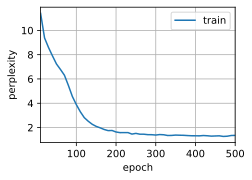

In [7]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

与上一节相比，由于深度学习框架的高级API对代码进行了更多的优化，该模型在较短的时间内实现了较低的困惑度。

## 小结

* 深度学习框架的高级API提供了循环神经网络层的实现。
* 高级API的循环神经网络层返回一个输出和一个更新后的隐藏状态，这个输出不涉及输出层的计算。
* 使用高级API实现的循环神经网络相比从零开始实现可以得到更快的训练速度。

## 练习

1. 你能使用高级API使循环神经网络模型过拟合吗？
1. 如果在循环神经网络模型中增加隐藏层的数量会发生什么？你能使模型正常工作吗？
1. 使用循环神经网络实现 :numref:`sec_sequence` 的自回归模型。


[Discussions](https://discuss.d2l.ai/t/2106)
